<a href="https://colab.research.google.com/github/hmelberg/health-analytics-using-python/blob/master/4_Organizing_your_data_The_answer_is_half_long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Choosing a Data Structure: The answer is half-long!

Hans Olav Melberg, Oslo, December, 2019


---



---



Often we have data that can be structured in many columns or rows, or even aggregated in one column. The question is  what format we should choose and how we can reshape the data to this format. For instance: A hospital event for a patient can be associated with many different diagnoses. There are at least three ways of organizing this information in a tabular format:
* **Wide with many columns**: The cells in each column has only one diagnostic code
* **Long in a single column**: All the relevant codes for the event are merged and separated by a comma or some other symbol
* **Long with many rows**: A single column for diagnoses and multiple rows for the same event with a a different diagnosis.

The choice of how to organize the data depends on several factors:
* **Memory**: Which structure uses the least memory?
* **Speed**: Which structure provides the quickest answers to common questions?
* **Ease of reasoning**: Which structure makes it easier to reason about the data and reorganize it to get the results you want? 

In this notebook we will explore the different structures and associated memory requirements and query speed. The aim is to provide information that is useful for choosing when to use the different data structures. Since tabular data tend to be easier to analyze if all codes related to the same event is in the same row, we will only compare different variants of wide and long structures and not the alternative where the same event is split in many rows.

The overall conclusion is perhaps surprising: A messy data-structure with multiple comma separated values in the same column seems to be both fast and memory efficient. 

### Import packages

In [0]:
import numpy as np
import pandas as pd
import time

# Make plots slighty bigger and cleaner
%config InlineBackend.figure_format = 'svg'

### Make data

We will use a function to create a dataframe since we want to easily repeating the process with different different number of individuals (n), and with different degrees of cardinality i.e. we might create data with only a few different diagnosis, or many possible diagnoses. 

Not all events should have the same number of diagnoses. Many will have just one or a few, but some will have more than 20. To simulate this distribution, the number of diagnoses associated with an event will be created by random draws from a [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution). 

Exercise:
If you believe single valued events are even more common than the negative binominal model suggests, try zero-inflated models. You could also try Poisson distributions. Hint: Read Josef Perktold's [notebook](https://gist.github.com/josef-pkt/c932904296270d75366a24ee92a4eb2f) on zero-inflated models. (Zero inflated in our context is really, "one-code-only-inflated', since all events have at least one diagnostic code.



In [0]:

def make_data(n, letters=26, numbers=100, seed=False):
  """
  Generate a dataframe with a column of random codes
  
  Args:
    letters (int): The number of different letters to use
    numbers (int): The number of different numbers to use

  Returns
    A dataframe with a column with one or more codes in the rows

  """
  # each code is assumed to consist of a letter and a number
  alphabet = list('abcdefghigjklmnopqrstuvwxyz')
  letters=alphabet[:letters+1]
  
  # make random numbers same if seed is specified
  if seed:
    np.random.seed(0)

  # determine the number of codes to be drawn for each event
  n_codes=np.random.negative_binomial(1, p=0.3, size=n)
  # avoid zero (all events have to have at least one code)
  n_codes=n_codes+1
  
  # for each event, randomly generate a the number of codes specified by n_codes
  codes=[]
  for i in n_codes:
      diag = [np.random.choice(letters).upper()+
              str(int(np.random.uniform(low=1, high=numbers))) 
              for num in range(i)]

      code_string=','.join(diag)
      codes.append(code_string)

  # create a dataframe based on the list   
  df=pd.DataFrame(codes)    
  df.columns=['code']
  
  return df


Let's see if it works:

In [0]:
 df = make_data(10000)
 df.head()

,code
0,D63
1,"Z75,R94,T2,F8,R5,S11,W14"
2,"V65,M31,Q43,R5,O5,F9,J99,O41,R79,W71,U25,A71"
3,"E19,P89,P54,L51,T47,N60,I15"
4,H44


The memory requirement of this dataframe with the codes for 10000 events is:


In [0]:
df.memory_usage().sum()

80128

In other words, in this structure with codes in a single merged column takes 80K to store the relevant information. We save this information for future reference, and give the dataframe a more meaningful name:


In [0]:
# a dataframe with all codes in one column
one_df=df.copy()
memory_one = one_df.memory_usage().sum()

## Memory use in the different data stuctures


We will now compare the following alternative structures for the columns with the codes:
1. **One** column with all codes as a comma separated string
2. **Many** columns with a single code in each cell
3. **Categorical** code columns datatype
4. **Sparse** code columns datatypes


The first step is to explore the memory requirement of the different structures for a dataframe of 10 000 events. Be aware that the conclusions from this exploration may not hold for other and larger dataframes. Something that is memory efficient and fast for 10 000 observations need not be equally good when you have 10 million observations or a different coding system. Still, it is good to do some explorations to find potential problems before doing a slightly more systematic analysis with different dataframes.


To go from a single column data-structure to multiple columns, we use the *.str.split(expand=True)* method:

In [0]:
df = one_df.code.str.split(',', expand=True)
many_df=many_df.add_prefix('code_')
many_df

,code_0,code_1,code_2,code_3,code_4,code_5,code_6,code_7,code_8,code_9,code_10,code_11,code_12,code_13,code_14,code_15,code_16,code_17,code_18,code_19,code_20,code_21,code_22,code_23,code_24,code_25
0,D63,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Z75,R94,T2,F8,R5,S11,W14,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,V65,M31,Q43,R5,O5,F9,J99,O41,R79,W71,U25,A71,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,E19,P89,P54,L51,T47,N60,I15,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,H44,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,H66,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9996,L73,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9997,Y31,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9998,G6,J5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In this structure there is only one code in every cell, but the problem with this structure is also obvious: The events with few codes, will have many missing values that take up space in the memory:

In [0]:
# memory use in a frame with cods in a separate columns
memory_many = many_df.memory_usage().sum()
memory_many/memory_one

23.963258785942493

The new dataframe uses between 20 to 30 times as much memory as the single column dataframe. The precise requirement depends on the number of codes for the event with the most codes. A single event with lots of codes could make the whole dataframe very large. For large datasets this is very expensive, and possibly impossibly large given memory constrains. For instance, a dataset with 10 million observations and 30 columns of diagnostic codes, could take more than 2.5 GB. In addition, we often have several sets of codes with the same structure: multiple diagnostic codes, multiple medical procedure codes, multiple surgical codes and so on. If we use many columns for all codes it could easily require 10 GB for 10 million observations. With 30 million observations it becomes almost impossible on most laptops since we would need very roughly 30 GB just for the dataframe itself.

There are at least two  steps we could take to reduce the memory problem and still maintain the principle of having a single code in a cell. The first is to use the categorical datatype i.e. instead of storing the actual code as a string, we store a number that corresponds to the code:

In [0]:
# Using astype('category') to reduce memory problems
categorical_df = many_df.astype('category')
memory_cetagorical = categorical_df.memory_usage().sum()
memory_cetagorical/memory_one

12.787539936102236

Using categorical variables halved the memory requirement compared to the multiple columns without categorical datatypes, but it is still more than ten times larger than the single column dataframe. 

Given that there are lots of missing values, we might try a third datatype - sparse - that is designed to handle precisely this kind of data:

In [0]:
# Using sparse datatype to reduce memory problems
sparse_df = many_df.astype(pd.SparseDtype("str", None))
memory_sparse = sparse_df.memory_usage().sum()
memory_sparse/memory_one

5.003744009584665

This is better, but it is still about five times larger than keeping alle the codes in a single column. 


##Summing up memory use in different structures

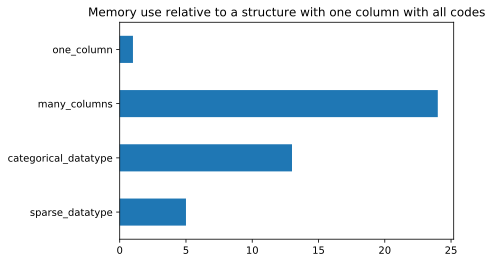

In [0]:
memory=[1, 24, 13, 5]
index = 'one_column many_columns categorical_datatype sparse_datatype'.split()
memory = pd.Series(memory, index=index)
# better layout, starting with the simplest case: searching in one column
memory = memory.iloc[::-1]
memory.plot.barh(title='Memory use relative to a structure with one column with all codes');

The structure where all codes are merged in one column, is far better than all the other data structures. This does not necessarily mean that it is best. People may find a merged column messy and difficult to use. Moreover, memory use is not really a problem unless you get close to the threshold where the data structure takes more memory than you have available. And even if you care about memory use below the threshold, a faster query time might outweigh the memory disadvantage. This means that to determine whether the extra memory cost is worth it, we should analyze the speed of performing a query with the different data structures.

## Speed of queries in the different data structures


One common data query is to find all events with a given code. For instance, with all the data merged in one column, we could search for events with the code T2 using *str.contains()*:

In [0]:
%%timeit
one_df.code.str.contains('T2')

100 loops, best of 3: 4.67 ms per loop


In our case a code cannot appear inside another code. If we have to eliminate this possibility, we have to use a regex when searching:


In [0]:
%%timeit
one_df.code.str.contains(r'\bT2\b')

100 loops, best of 3: 7.71 ms per loop


In other words, using a regex it takes almost twice as long. 

How long will it take to do the same searches in the other data structures? Lets start by identifying events with 'T2' in the dataframe where the codes are in many separate columns:

In [0]:
%%timeit
many_df=='T2'

100 loops, best of 3: 15.7 ms per loop


Searching for T2 in multiple columns takes about twice as long as searching with a regex in a single column. If all we are interested is whether the event has a code, we also have to use *any()*:

In [0]:
%%timeit
(many_df=='T2').any(axis=1)

100 loops, best of 3: 16.2 ms per loop


The *any()* was cheap and did not add much time to the calculation. 

Before we check more data structures, one should also examine whether the method *isin()* is faster than using the equality test *==*:


In [0]:
%%timeit
many_df.loc[:,:].isin(['T2'])

100 loops, best of 3: 5.11 ms per loop


Interestingly, *isin()* is faster than using *==* when searching multiple columns even when we only search for a single code. This is somewhat surprising - and useful. To quote something some Bayesians probably preaches: Non-intuitive truths are worth more than obvious truths.

Let's see if the speed of *isin()*  also applies to categorical datatypes. Compare the result using *==* vs. *isin()* when we have categorical data:


In [0]:
%%timeit
categorical_df == 'T2'

100 loops, best of 3: 11.2 ms per loop


Having categorical datatypes makes the search quicker, but it is still slower than the single column search.

In [0]:
%%timeit
categorical_df.loc[:,:].isin(['T2'])

100 loops, best of 3: 16.9 ms per loop


Surprisingly - again - this time *isin()* is slower: With categorical datatypes *isin()* seems to be slower than *==* when we search for single values (At least in our example with a relatively small dataframe. The sheep may be black if we have a different dataframe.

Lastly, how slow is the sparse dataframe?

In [0]:
%%timeit
(sparse_df=='T2').any(axis=1)

10 loops, best of 3: 27.8 ms per loop


The sparse data structure is slowest so far. More than 5 times slower than the one merged column structure.

In [0]:
%%timeit
sparse_df.loc[:,:].isin(['T2']).any(axis=1)

10 loops, best of 3: 22.7 ms per loop


Using *isin()* with a sparse dataframe and a single search value made it a little faster.

## Speed summary, so far


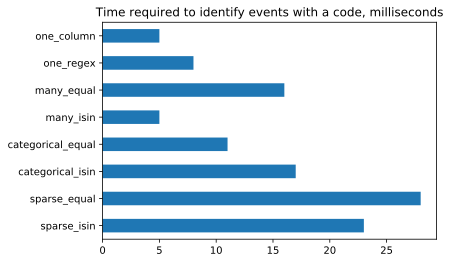

In [0]:
speed=[5, 8, 16, 5, 11, 17, 28, 23]
index = 'one_column one_regex many_equal many_isin categorical_equal categorical_isin sparse_equal sparse_isin'.split()
speed = pd.Series(speed, index=index)
# better layor, starting with the simplest case: searching in one column
speed = speed.iloc[::-1]
speed.plot.barh(title='Time required to identify events with a code, milliseconds');

The explorative analysis so far indicates that the single column data structure is both the most memory efficient and the quickest data structure when we want to search for events with a given code. It may not be very clean, but the savings seem to be significant. For instance, if - OK, a big if! - we extrapolate from our explorative analysis, it would take more than 20 seconds to query a sparse datastructure with 10 million rows, while the same search would take 5 seconds with all codes merged in a single column.



## Does increasing the size of the dataframes or the number of codes in the search change the results?

The results so far should be taken with a bucket of salt. For instance, if we have a larger dataframe or search for more than one code, we may get different relative results. The next step is to experiment with different sizes and structures to seem how these changes affect the results. This is easier to do if we have the memory and speed checks in a function:

In [0]:

def check(df, ncodes=1):
  """
  Returns memory use and query time for different structures of the dataframe

  Args:
    df: a dataframe with one columm of codes, merged and comma separated
    ncodes: the number of codes to search for

  Note: The results could be affected by other processes. Repeat for consistency 
  """

  mem={}
  search={}
  df.columns=['d']
  
  mem['one'] = df.memory_usage().sum()
  
  df_exploded = df.d.str.split(',', expand=True)
  mem['many'] = df_exploded.memory_usage().sum()/mem['one']
  
  df_category = df_exploded.astype('category')
  mem['category'] = df_category.memory_usage().sum()/mem['one']
  
  df_sparse = df_exploded.astype(pd.SparseDtype("str", np.nan))
  mem['sparse'] = df_sparse.memory_usage().sum()/mem['one']
  
  df_merged_category=df.astype('category')
  mem['one_category'] = df_merged_category.memory_usage().sum()/mem['one']

  unique_codes = list(set(df_exploded.loc[:,0].unique()))
  search_terms = np.random.choice(unique_codes, size=ncodes, replace=False)
  
  search_terms_regex = '|'.join([rf'\b{term}\b' for term in search_terms])

  start = time.time()
  df.d.str.contains(search_terms_regex).sum()
  end = time.time()
  search['one'] = (end-start)

  start = time.time()
  df_exploded.isin(search_terms).values.sum()
  end = time.time()
  search['many'] = (end-start)/search['one'] 

  start = time.time()
  df_category.isin(search_terms).values.sum()
  end = time.time()
  search['category'] = (end-start)/search['one']
  
  start = time.time()
  df_sparse.isin(search_terms).values.sum()
  end = time.time()
  search['sparse'] = (end-start)/search['one']

  start = time.time()
  df_merged_category.d.str.contains('|'.join(search_terms)).values.sum()
  end = time.time()
  search['one_category'] = (end-start)/search['one']

  df_merged_category.d.str.contains(search_terms_regex).values.sum()
  end = time.time()
  search['one_category_regex'] = (end-start)/search['one']
  
  return mem, search
  

## Guesses. Hopefully Educated 

Before running the function to test the memory use and query speeds with different data structures, it is possible to make some educated guesses as to how the different variables will affect the results. In this way we also learn something about why one structure is good or bad, and not just "this is the way it is."

First, the category datatype will be beneficial if the number of codes is relatively low compared to the overall number of events (also called [low cardinality](https://en.wikipedia.org/wiki/Cardinality_(SQL_statements))). So far we have used a relatively small dataframe, and increasing the size of the dataframe should improve the relative memory performance of the categorical data structure.

Second, the format of one column with merged codes will probably continue to perform well even if we add more codes to the search. Why? If it is smart - which I think it is - it will not conduct wasteful searches. That is, if you search for multiple codes, and it finds the first code, there is no need to search for the second code. The event is already marked as "having one of the codes." In this way a regex search in a single column will probably continue to be relatively fast even with larger dataframes. The more codes, the relatively faster it will be.

The performance of the sparse structure will - naturally - depend on the sparseness of the data. If we have many events with missing codes, it will do better than if we have many events with many codes.

All in all, and perhaps surprisingly, the hypothesis is that the single column with merged codes will continue to perform well. It is somewhat surprising since string searches are often time-consuming, and checking for equality of numbers is quicker. However, it seems like those who implemented the *str.contains()* method in Pandas did a very good job at making it fast - even with regex.


## How does the size of the dataframe affect the results?

Let us examine the memory requirements and the time it takes to search for a code when we increase the size of the dataframe from 1 to 9 million events in incremental steps of 1 million:

In [0]:
# make and check different sized dataframes
# warning: This can take along time, around 30 minutes

mems=[]
searches=[]
for n in range(1000000,10000000,1000000):
  df=make_data(n=n)
  mem, search = check(df=df)
  mems.append(mem)
  searches.append(search)


### Memory requirement of larger dataframes

In [0]:
# convert the results to a dataframe
mem_df = pd.DataFrame(mems, index = range(1000000,10000000,1000000))

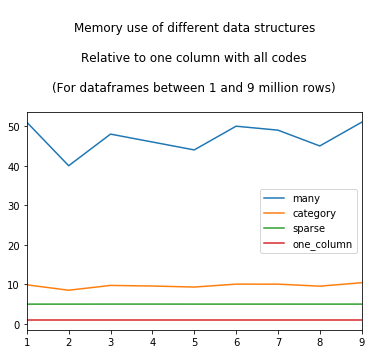

In [0]:
# plot it

# one column structure is the reference category
mem_df['one_column'] = 1

# measure dataframe size in millions of rows
mem_df.index=mem_df.index/1000000

mem_df.iloc[:,[1,2,3,5]].plot(title="""
Memory use of different data structures

Relative to one column with all codes

(For dataframes between 1 and 9 million rows)
""");

The relative differences are very stable: One column with all the codes is the most memory efficient for dataframes of all sized between 1 and 9 millions, and the structure with many columns is more than 40 times worse. The multiple columns with sparse datatypes is the second best, but it is still five times worse, and the multiple columns with categorical datatypes takes ten times as much memory as the one column version.

To get an idea of how bad it is to be 40 times worse etc, we might plot the absolute memory requirement for a one column dataframe as the size of the dataframe increases:

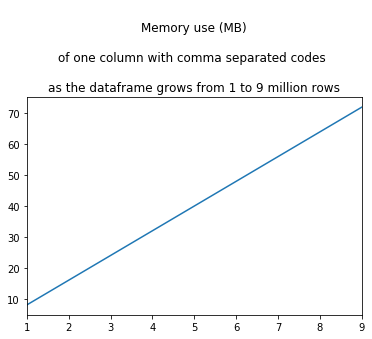

In [0]:
mem_df['one'].div(1000*1000).plot(title="""
Memory use (MB)

of one column with comma separated codes 

as the dataframe grows from 1 to 9 million rows""");

Very roughly, 10 million rows would take almost 100 MB in a one column structure, and almost 4 GB in a multi column structure.

### Speed of searches in larger dataframes

The figure below plots how much time it takes to search for a code in the other structures compared to the one column search (which is normalized to 1):

In [0]:
search_df = pd.DataFrame(searches, index =range(1,10,1))

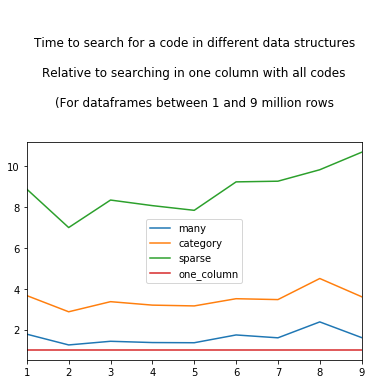

In [0]:
search_df['one_column']=1

search_df.iloc[:,[1,2,3,6]].plot(title="""

Time to search for a code in different data structures

Relative to searching in one column with all codes

(For dataframes between 1 and 9 million rows)

""");

Once again, the picture is consistent across different dataframe sizes: Searching takes the least time in a one column structure, and the most time in a sparse datatype. Searching in multiple columns (using *isin()*) is almost as fast as the one-column structure, while categorical datatypes seem slow.

To get an idea of the absolute time requirement for a search, the figure below plots the time (in seconds) it takes to search for a code in a one column structure.

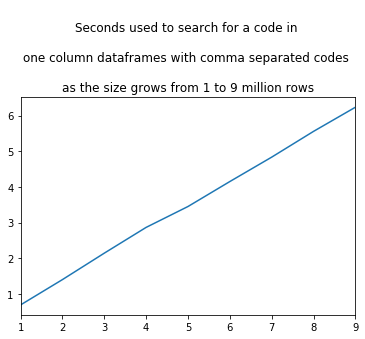

In [0]:
search_df['one'].plot(title="""
Seconds used to search for a code 

in one column dataframes with comma separated codes 

as the size grows from 1 to 9 million rows""");

The search time grows linearly and it takes less than ten seconds to query codes in ten million rows when they are merged in one column. The worst data-structure for searching, is the sparse datatype, which is approaching 100 seconds.

##Searching for more than one code

So far we have searched for only one code. Do the results change if we search for many codes at the same time. Not only T2 (Ford!), but also M3 (Tesla!). Or, more seriously: Select a random set of codes of size 1 to 10 and examine how long time it takes to search for rows with one of these codes in the different data structures:

In [0]:
mems2=[]
searches2=[]
for n in range(1,10,2):
  df=make_data(n=1000000)
  mem, search = check(df=df, ncodes=n)
  mems2.append(mem)
  searches2.append(search)

In [0]:
search_df2 = pd.DataFrame(searches2, index = range(1,10,2))
search_df2['one_column'] = 1

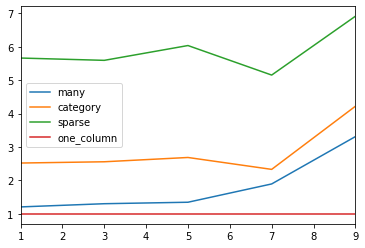

In [0]:
search_df2.iloc[:,[1,2,3,6]].plot();

In short, the one column data structure continues to perform well, and as the number of codes gets gets closer to ten, it seems to do perform relatively better than the other data-structures. 

## How to transform a dataframe from one structure to another

If - and we still need to use a slightly salty *if* - the one column data structure really is both faster and smaller than the other data structures, the question becomes how you can create this datastructure. If you have been handed a file with separate columns for diagnoses, how do you merge the codes in these columns to a single column with comma separated values?

Often these files have millions of observations and dozens of columns with diagnoses. Merging millions of rows for dozens of columns can be very time consuming, which means that we not only need a method that works, but one that works efficiently. Once again we can use *%%timeit* to experiment with different approaches.


In [0]:
df = make_data(n=100000)

In [0]:
df.columns=['code']
df = df['code'].str.split(',', expand=True)
df = df.add_prefix('code_')
df.head()


,code_0,code_1,code_2,code_3,code_4,code_5,code_6,code_7,code_8,code_9,code_10,code_11,code_12,code_13,code_14,code_15,code_16,code_17,code_18,code_19,code_20,code_21,code_22,code_23,code_24,code_25,code_26,code_27,code_28,code_29,code_30,code_31,code_32,code_33,code_34,code_35,code_36,code_37
0,A16,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,P12,Q60,Y10,Z73,C54,R60,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,D60,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,A80,G92,W85,E53,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,B42,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [0]:
# concatenate content from many columns to one string
many_df = many_df[code_columns[0]].str.cat(many_df[code_columns[1:]], sep=',', na_rep='').str.rstrip(',')
many_df.head()

### Here are some approches we might try
1. *cat': Using pandas own *.str.cat()* method (starting with a single column we can use this to concatenate it and the other columns)
2. *sum*: Interestingly *sum()* also works on text - and combined with groupby we could use this to "sum" all the diagnoses for an event (sum can take an axis keyword i.e. we can sum horizontally by writing *sum(axis=1)*
3. *pd.Series()*: We make a single series of all the columns
4. *apply*: Use *apply()* and *set*, or *apply()* and a *lambda* function that merges the codes
5. *list comprehensions* Loop over the rows and make a string of codes in all columns

In addition to the general approach highlighted by the keywords above, we also need to take care of a few details:
* We have to make sure that all columns we merge contain strings and not floats, integers or other datatypes (If we are sure it already has the correct datatype. this step in unnecessary and we may speed up the process.)
* We want to avoid listing missing values as a code, and in general we need an approach to handle missing values (skip or delete)
* We may need to do some munging to make sure that there are no space around the code, not too many commas and so on

The code, and the time it takes to create a merged column, is presented below:


In [0]:
columns = df.columns

Using *str.cat()* to concatenate the first and all the other columns 

In [0]:
def merge(df):
  columns = list(df.columns)
  comma_separated_columns=[]
  df['comma']=','
  for col in columns:
    comma_separated_columns.append(col)
    comma_separated_columns.append('comma')
  seconds={}

  strcat = %timeit -o df[columns[0]].str.cat(df[columns[1:]], sep=',', na_rep='').str.rstrip(',')
  summing = %timeit -o df[comma_separated_columns].fillna('').sum(axis=1)
  series = %timeit -o pd.Series(df[columns].fillna('').values.tolist()).str.join(sep=',').str.rstrip(',')
  apply = %timeit -o df[columns].fillna('').apply(','.join, axis=1).str.rstrip(',')
  list_comprehension = %timeit -o [','.join(row).rstrip(',') for row in df[columns].fillna('').values]
    
  seconds['strcat'] = strcat
  seconds['summing'] = summing
  seconds['series'] =  series
  seconds['apply'] = apply
  seconds['list_comprehension'] = list_comprehension

  return seconds

Next we use the merge function on dataframes with different sizes and record the time it takes:

In [0]:
speed_for_size={}
for n in range(10000,100000,30000):
  print(n)
  df = make_data(n=n)
  df.columns=['code']
  df = df['code'].str.split(',', expand=True)
  df = df.add_prefix('code_')
  df=df.fillna(np.nan)
  columns=df.columns
  comma_separated_columns=[]
  df['comma']=','
  df=df.astype(str)
  for col in columns:
    comma_separated_columns.append(col)
    comma_separated_columns.append('comma')
  speed = merge(df=df)
  best_speed= {name: results.best for name, results in speed.items()}
  speed_for_size[n] = pd.Series(best_speed)

10000
10 loops, best of 3: 50.7 ms per loop
10 loops, best of 3: 111 ms per loop
10 loops, best of 3: 53.4 ms per loop
1 loop, best of 3: 209 ms per loop
10 loops, best of 3: 52.3 ms per loop
40000
1 loop, best of 3: 246 ms per loop
1 loop, best of 3: 547 ms per loop
1 loop, best of 3: 303 ms per loop
1 loop, best of 3: 884 ms per loop
1 loop, best of 3: 242 ms per loop
70000
1 loop, best of 3: 522 ms per loop
1 loop, best of 3: 1.1 s per loop
1 loop, best of 3: 588 ms per loop
1 loop, best of 3: 1.61 s per loop
1 loop, best of 3: 452 ms per loop


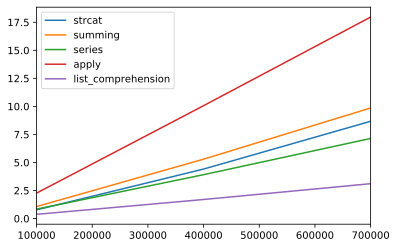

In [0]:
speed_df = pd.DataFrame(speed_for_size).T
speed_df.plot();

Concerted to dataframe and plotted, we see that the quickest merge method, given the datastructure we have, is list comprehension:
```
[','.join(row).rstrip(',') for row in df[columns].fillna('').values]
```

The differences between the methods seem stable, but just to make sure, we could try a dataframe with three million observations:

In [0]:
# Note: This takes several minutes to execute 
n=3000000
df = make_data(n=n)
df.columns=['code']
df = df['code'].str.split(',', expand=True)
df = df.add_prefix('code_')
df=df.fillna(np.nan)
columns=df.columns
comma_separated_columns=[]
df['comma']=','
for col in columns:
  comma_separated_columns.append(col)
  comma_separated_columns.append('comma')
df.head()

In [0]:
  speed = merge(df=df)
  best_speed= {name: results.best for name, results in speed.items()}
  speed_for_size = pd.Series(best_speed)

1 loop, best of 3: 29.4 s per loop
1 loop, best of 3: 45.1 s per loop
1 loop, best of 3: 21.5 s per loop
1 loop, best of 3: 1min 10s per loop
1 loop, best of 3: 18.7 s per loop


With 30 million rows, this process could take more than 10 minutes if you used the worst method (apply). The fastests method would take about 3 minutes. Even if you only this once, it is important to avoid apply when mering text columns.


# Summing up

The conclusion is as stark as it is surprising: Not only is having all codes in a single column very memory efficient, it is also the fastests structure to search for the existence of a group of codes.

It may not be the prettiest solution. For instance, Hadley Wickham has argued in favor of a long data structure because it makes it easier to reason about the data. Having all codes in one column long in the sense that we avoid lots of columns like *diagnosis_1*, *diagnosis_2* etc that are typical symptoms of a wide structure. However, merging all the information on one column is perhaps half-long. We do not go all the way: having a single valued cell with a single diagnosis on each row. But we do not go wide either. 


In the end it the data structure depends on the kind of questions you would like to be answered. For instance, if you were to do grupby on a single code, this would be more difficult when you have a merged diagnostic column. However, in my experience, we commonly do groupby's on groups of codes (e.g. all cancer codes), which would require a selection those events that belong to the group first - which, in turn, requires a fast structure for marking rows with different diagnoses.


# Afternotes
A radically different approach would be to store the data in a database instead of a tabular structure. To save memory it is often sensible to store large data in databases, but the starting point of this notebook is not the optimal storage of data alone. True, tabular dataformats are wasteful: We often repeat the gender for the same person in different rows and so on. But a tabular format is still very useful for analysis. For instance, we avoid having to repeatedly join information from many separate tables and analyzing results by different sub-groups (groupby's) is quick and non-verbose. The tabular format makes it easier to analyze the data. The best formats to store the data need not be the best format to analyze the data. The argument in this notebook is not that all data should be stored in a half-long tabular structure. Instead, the argument made in this notebook is about medium sized data dataset you get after it has been extracted from a very large database. 


# Further reading
Hadley Wickham has a good discussion of how data should be structured: [Tidy data](https://vita.had.co.nz/papers/tidy-data.pdf) 